In [30]:
# import libraries and packages
import pandas as pd
from datetime import datetime, timedelta
import requests


In [16]:
base_url = "https://stablecoinstats.com/api/historical/"
stablecoins = ["USDT", "USDC", "DAI"]

# Define the date range for historical data
today = datetime.today()
start_date = datetime(2024, 1, 1)  # Adjust start_date as needed

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each date and stablecoin
for date in pd.date_range(start_date, today):
    date_str = date.strftime("%Y-%m-%d")
    for stablecoin in stablecoins:
        try:
            url = f"{base_url}{date_str}/{stablecoin}"
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for non-200 status codes

            # Extract the relevant data from the response
            daily_data = response.json()
            daily_data["date"] = date
            daily_data["symbol"] = stablecoin
            # Convert dictionary to Series and append to DataFrame
            data = pd.concat([data, pd.Series(daily_data).to_frame().T], ignore_index=True)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {stablecoin} on {date}: {e}")


In [3]:
data = pd.read_csv("stable_full.csv")

In [17]:
data.head()

,circulation,circulation_change_24h,circulation_percent_change_24h,name,price,price_percent_change_24h,symbol,treasury,volume,volume_change_24h,volume_percent_change_24h,date,error
0,89934940724.734283,4199000.0,0.004669,Tether USD,1.036073,0.246772,USDT,"{'erc20_balance': 701385261.170399, 'erc20_sup...",2703467229.637532,272073215.89536,11.190009,2024-01-01,NaN
1,22215227519.546036,35715839.086773,0.161031,USD Coin,1.002286,0.176066,USDC,NaN,350231001.930338,2707072.628884,0.77896,2024-01-01,NaN
2,3715936931.109233,18592762.418408,0.502868,Dai,1.009176,0.452021,DAI,NaN,9429316.550889,848733.831538,9.891331,2024-01-01,NaN
3,90282930467.074295,347989742.340012,0.386935,Tether USD,1.015506,-2.015991,USDT,"{'erc20_balance': 441016256.170399, 'erc20_sup...",6209126723.857304,3605167384.213016,138.44945,2024-01-02,NaN
4,22384205593.358215,188031304.817207,0.847134,USD Coin,1.00006,-0.274931,USDC,NaN,798793097.337534,456552486.547799,133.401026,2024-01-02,NaN


In [18]:
df = data
dict_df = pd.json_normalize(df['treasury'])
df = pd.concat([df.drop(columns=['treasury']), dict_df], axis=1)

In [19]:
df.head()

,circulation,circulation_change_24h,circulation_percent_change_24h,name,price,price_percent_change_24h,symbol,volume,volume_change_24h,volume_percent_change_24h,date,error,erc20_balance,erc20_supply,omni_balance,omni_supply,quarantined_balance,trc20_supply,tron_balance
0,89934940724.734283,4199000.0,0.004669,Tether USD,1.036073,0.246772,USDT,2703467229.637532,272073215.89536,11.190009,2024-01-01,NaN,7.013853e+08,4.200782e+10,7.018042e+08,888000000.0,31304655.0,4.882026e+10,3.466455e+08
1,22215227519.546036,35715839.086773,0.161031,USD Coin,1.002286,0.176066,USDC,350231001.930338,2707072.628884,0.77896,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3715936931.109233,18592762.418408,0.502868,Dai,1.009176,0.452021,DAI,9429316.550889,848733.831538,9.891331,2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90282930467.074295,347989742.340012,0.386935,Tether USD,1.015506,-2.015991,USDT,6209126723.857304,3605167384.213016,138.44945,2024-01-02,NaN,4.410163e+08,4.200782e+10,7.018042e+08,888000000.0,31304655.0,4.882026e+10,2.590247e+08
4,22384205593.358215,188031304.817207,0.847134,USD Coin,1.00006,-0.274931,USDC,798793097.337534,456552486.547799,133.401026,2024-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Ensure 'price' and 'volume' are numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

# Group by 'symbol' and then apply rolling window calculations
# This ensures calculations are done per stablecoin

# Moving Averages for price, grouped by symbol
df['price_ma7'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=7).mean())
df['price_ma30'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=30).mean())

# Moving Averages for volume, grouped by symbol
df['volume_ma7'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=7).mean())
df['volume_ma30'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=30).mean())

# Volatility Indices: Price standard deviation over the dataset (simplified example), grouped by symbol
df['price_std'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=3).std())

# Example of handling missing values by forward filling (use cautiously)
# It's applied globally here, but you might want to consider handling missing values within each group separately
df.fillna(method='ffill', inplace=True)

# Normalization (Min-Max scaling)
# Ensure this is appropriate for your use case, especially when applied after grouping
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# If you need to scale within each group, you'll have to apply the scaler within a groupby operation
df[['circulation', 'volume']] = scaler.fit_transform(df[['circulation', 'volume']])



In [21]:
# Assuming 'df' is your DataFrame

# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)


                                circulation  circulation_change_24h  \
circulation                        1.000000                0.441474   
circulation_change_24h             0.441474                1.000000   
circulation_percent_change_24h     0.086161                0.491772   
price                              0.782297                0.222828   
price_percent_change_24h          -0.006763               -0.087559   
volume                             0.815763                0.534958   
volume_change_24h                  0.014533                0.117147   
volume_percent_change_24h          0.029889                0.068702   
erc20_balance                      0.010292                0.008367   
erc20_supply                       0.010745                0.065452   
omni_balance                       0.013509                0.166014   
omni_supply                             NaN                     NaN   
quarantined_balance                     NaN                     NaN   
trc20_

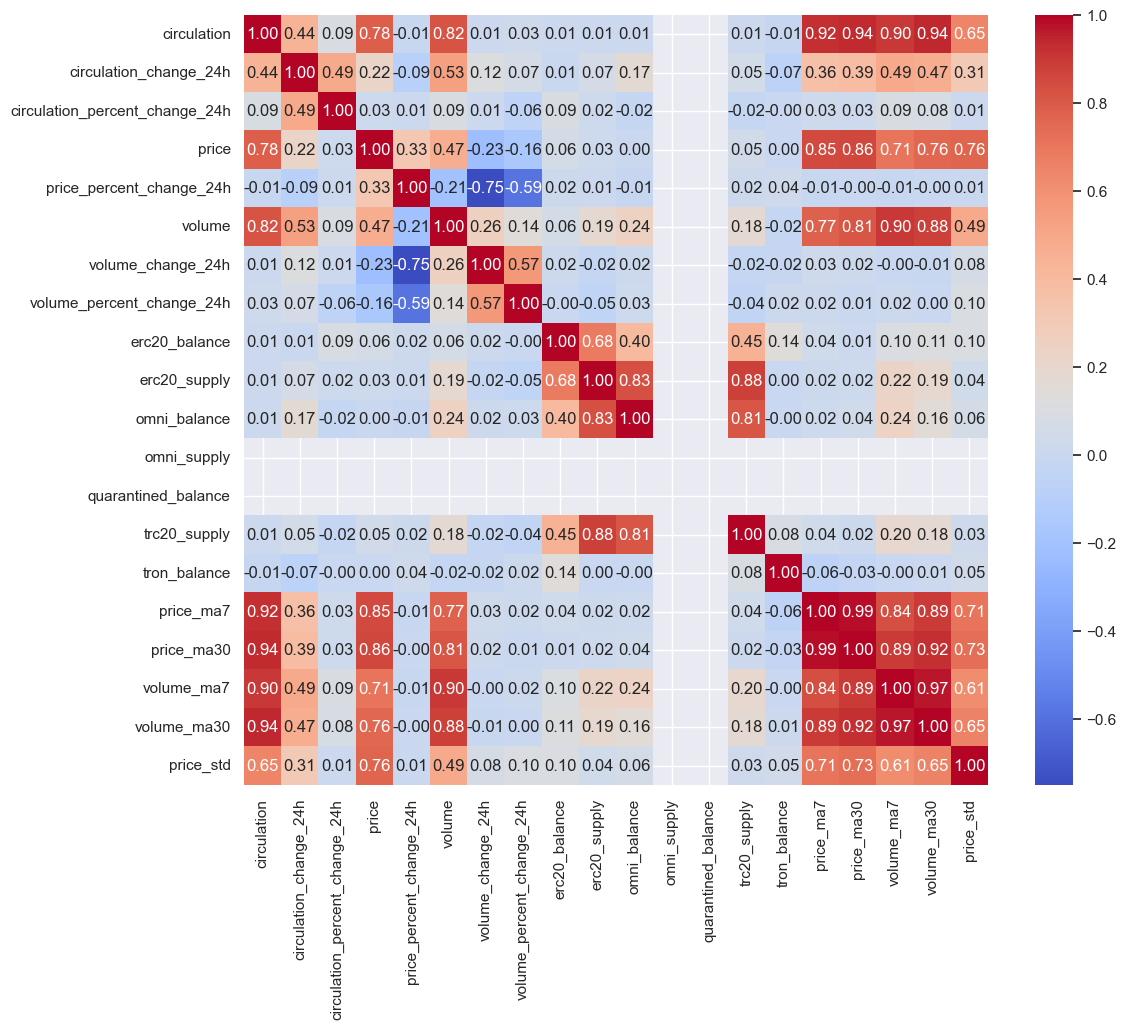

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'correlation_matrix' is your computed correlation matrix
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()


In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

df_enhanced = df
# Enhanced Data Preprocessing and Feature Engineering
# Note: For simplicity, we're directly using the new features without additional engineering in this example.
features = df_enhanced[['price', 'price_percent_change_24h', 'volume', 'volume_change_24h', 'volume_percent_change_24h']]
scaled_features = scaler.fit_transform(features)

# Model Initialization with Hyperparameter Tuning
# Note: Due to the demonstration nature, we're using predefined parameters.
model_enhanced = OneClassSVM(kernel="rbf", gamma='auto')
parameters = {'nu': [0.01, 0.05, 0.1]}

# Splitting data into training and testing sets for evaluation purposes
# Note: In a real-world scenario, especially for unsupervised tasks like anomaly detection, this step might differ.
X_train, X_test = train_test_split(scaled_features, test_size=0.3, random_state=42)

# Grid Search for parameter tuning (simulated here as we only use OneClassSVM without GridSearchCV due to its unsupervised nature)
model_enhanced.fit(X_train)

# Predicting anomalies on the test set
predictions_enhanced = model_enhanced.predict(X_test)
anomalies_enhanced = X_test[predictions_enhanced == -1]

anomalies_enhanced

array([[1.56616342e-01, 4.06094586e-01, 4.70730644e-01, 6.34553853e-01,
        3.02612478e-01],
       [7.55433511e-01, 5.83692863e-01, 8.18979500e-02, 4.54420923e-01,
        1.43725780e-01],
       [4.16686788e-01, 6.04142540e-01, 3.86110630e-01, 1.19275181e-01,
        7.28610376e-02],
       [2.58990158e-02, 4.42665676e-01, 8.51782616e-02, 4.37584627e-01,
        1.17856519e-01],
       [6.90527563e-01, 6.51612619e-01, 2.31402432e-01, 2.80907243e-01,
        7.91584246e-02],
       [2.51009221e-01, 5.50169708e-01, 2.85518190e-01, 2.43487846e-01,
        8.16832353e-02],
       [3.54406835e-01, 3.91314891e-01, 5.72161804e-01, 6.52812120e-01,
        2.91306549e-01],
       [5.64471120e-01, 6.92026440e-01, 1.24745745e-01, 2.56843558e-01,
        2.58189553e-02],
       [7.62032423e-01, 7.36276943e-01, 1.38527681e-01, 3.33885373e-01,
        6.48670906e-02],
       [2.03177068e-02, 4.66033223e-01, 4.11239765e-02, 4.56944593e-01,
        1.14093709e-01],
       [1.70640413e-01, 4.4721

In [24]:
import numpy as np
# Assuming 'price' is a feature in your dataset and scaled_features is derived from it
# Reverse scaling to get original price values for label simulation
original_prices = scaler.inverse_transform(X_test)[:, 0]  # Assuming 'price' is the first feature

# Generate true labels based on the price being within 1 ± 0.10
true_labels_test = np.where((original_prices >= 0.90) & (original_prices <= 1.10), 0, 1)

# The mapping of predictions remains the same
mapped_predictions_enhanced = np.where(predictions_enhanced == -1, 1, 0)

# Calculate and print the classification report
report = classification_report(true_labels_test, mapped_predictions_enhanced, target_names=['Normal', 'Anomaly'])
print(report)


              precision    recall  f1-score   support

      Normal       1.00      0.60      0.75        75
     Anomaly       0.00      0.00      0.00         0

    accuracy                           0.60        75
   macro avg       0.50      0.30      0.37        75
weighted avg       1.00      0.60      0.75        75



/Users/peter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/peter/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
true_labels_test,  mapped_predictions_enhanced

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1]))

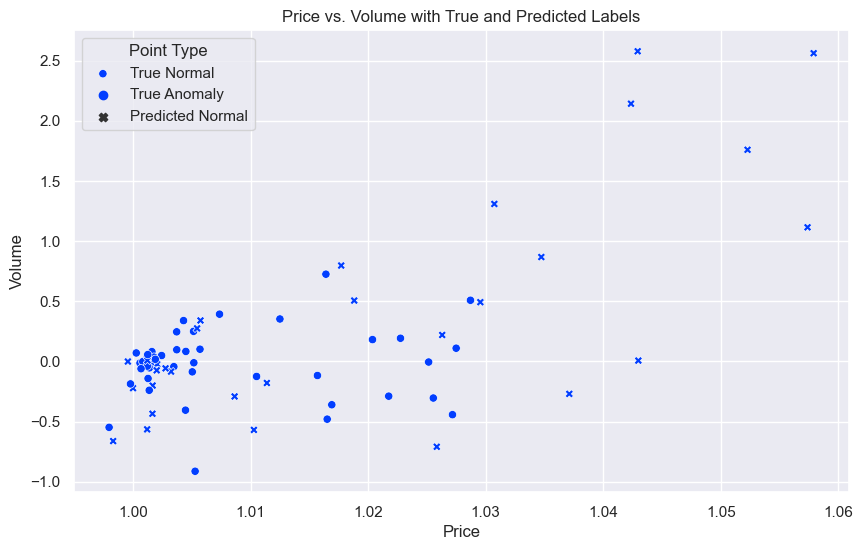

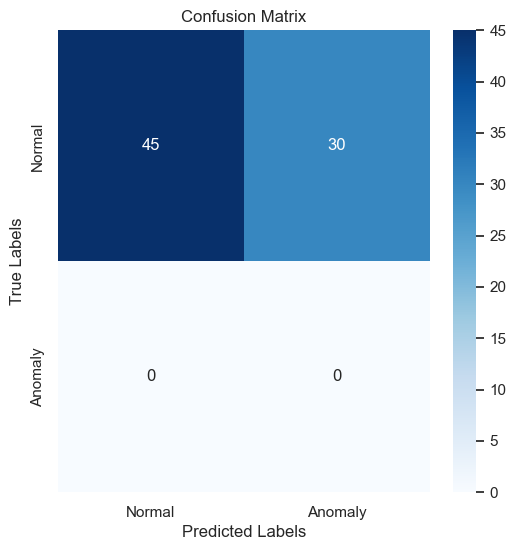

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()



# Scatter Plot - Assuming 'price' and 'volume' are the first two features for visualization
# Reverse scaling for visualization purposes
original_features = scaler.inverse_transform(X_test)
original_prices = original_features[:, 0]  # Assuming 'price' is the first feature
original_volumes = original_features[:, 1]  # Assuming 'volume' is the second feature for demonstration

plt.figure(figsize=(10, 6))
sns.scatterplot(x=original_prices, y=original_volumes, hue=true_labels_test, style=mapped_predictions_enhanced, palette="bright")
plt.title('Price vs. Volume with True and Predicted Labels')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.legend(title='Point Type', labels=['True Normal', 'True Anomaly', 'Predicted Normal', 'Predicted Anomaly'])
plt.grid(True)
plt.show()

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(true_labels_test, mapped_predictions_enhanced)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


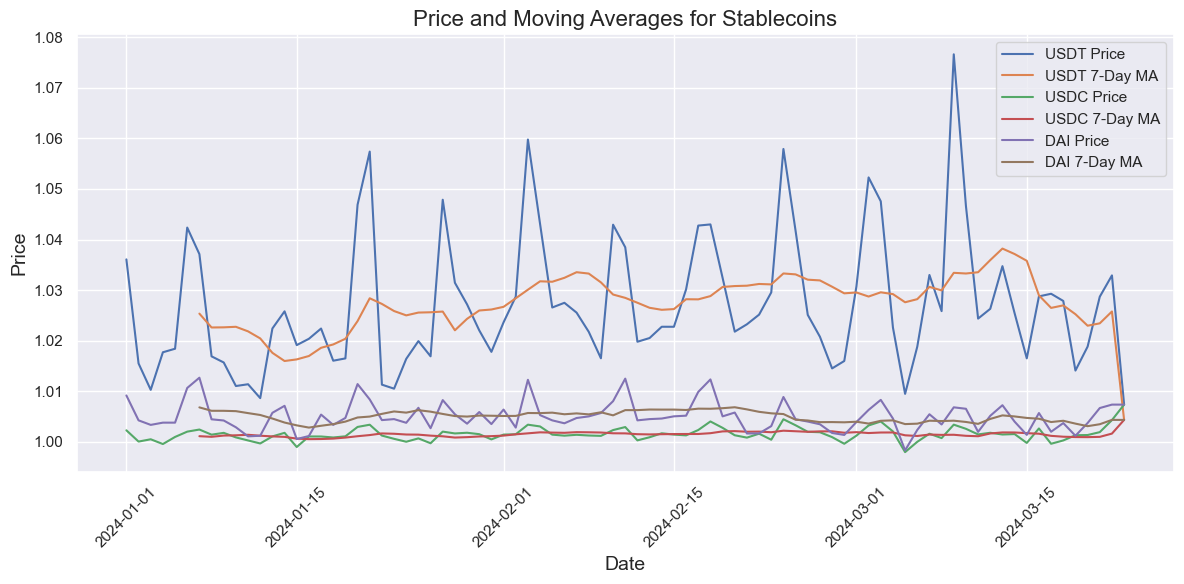

In [27]:

# Plotting with seaborn
plt.figure(figsize=(12, 6))

# Plotting each symbol with seaborn lineplot
for symbol in df['symbol'].unique():
    subset = df[df['symbol'] == symbol]
    sns.lineplot(x='date', y='price', data=subset, label=f"{symbol} Price")
    sns.lineplot(x='date', y='price_ma7', data=subset, label=f"{symbol} 7-Day MA")

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Price and Moving Averages for Stablecoins', fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import IsolationForest



In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

# Assuming 'features' and 'df' are already defined and 'scaler' is fitted to your dataset
scaled_features = scaler.transform(features)
original_prices = scaler.inverse_transform(scaled_features)[:, 0]  # Adjust index if 'price' is not the first feature

# Simulate labels for the entire dataset based on your condition
y_simulated = np.where((original_prices >= 0.98) & (original_prices <= 1.02), 0, 1)

# Now, split your dataset into training and testing sets using the simulated labels
X_train, X_test, y_train_simulated, y_test_simulated = train_test_split(
    scaled_features, y_simulated, test_size=0.3, random_state=42
)

# Adjust the custom_scorer to work with the simulated labels
def custom_scorer(y_true, y_pred):
    y_pred = np.where(y_pred == -1, 0, 1)  # Flip labels because Isolation Forest uses -1 for anomalies which we map to 1
    return f1_score(y_true, y_pred)

# Initialize the model
iso_forest = IsolationForest(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=make_scorer(custom_scorer, greater_is_better=True), cv=5)

# Note: Make sure the custom_scorer and GridSearchCV are set up to handle the 0s and 1s as normal and anomaly labels respectively
grid_search.fit(X_train, y_train_simulated)

# After finding the best parameters, evaluate on X_test and y_test_simulated
best_model = grid_search.best_estimator_
predictions_test = best_model.predict(X_test)
mapped_predictions_test = np.where(predictions_test == -1, 1, 0)  # Aligning with your labeling scheme



In [42]:
# Directly calculate confusion matrix components
cm = confusion_matrix(y_test_simulated, mapped_predictions_test)

if cm.shape == (1, 1):
    # Assuming the only class present in y_test_simulated is 0 (normal)
    tn = cm[0, 0]
    fp = 0  # No false positives if no anomalies were predicted
else:
    tn, fp, fn, tp = cm.ravel()

# Assuming anomalies are rare/absent in the test set and focusing on false positives
print(f"True Negatives (Correctly identified as Normal): {tn}")
print(f"False Positives (Normal instances incorrectly flagged as Anomalies): {fp}")

# Adjusted precision, recall calculation for cases with no true positives
precision = 0 if fp == 0 else 'Undefined'  # Precision is not defined when there are no positive predictions
recall = 'Not applicable'  # Recall is not applicable in this context as there are no true anomalies in the test set
f1 = 'Not applicable'  # F1 is not applicable without true positive predictions

print(f"Precision (of Anomaly detection): {precision}")
print(f"Recall (of Anomaly detection): {recall}")
print(f"F1 Score (of Anomaly detection): {f1}")


True Negatives (Correctly identified as Normal): 55
False Positives (Normal instances incorrectly flagged as Anomalies): 0
Precision (of Anomaly detection): 0
Recall (of Anomaly detection): Not applicable
F1 Score (of Anomaly detection): Not applicable


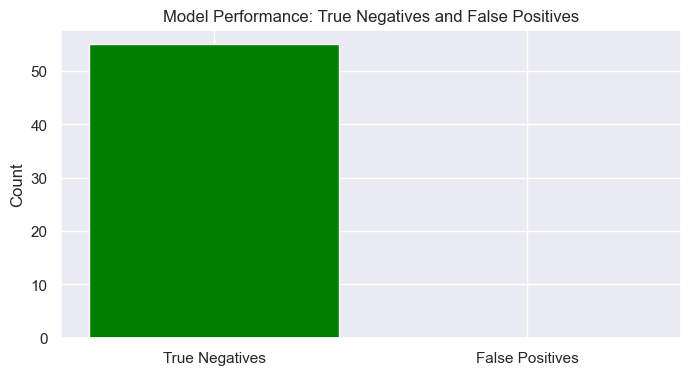

In [44]:
import matplotlib.pyplot as plt

# Assuming tn and fp are defined as before
metrics = ['True Negatives', 'False Positives']
values = [tn, fp]

plt.figure(figsize=(8, 4))
plt.bar(metrics, values, color=['green', 'red'])
plt.title('Model Performance: True Negatives and False Positives')
plt.ylabel('Count')
plt.show()


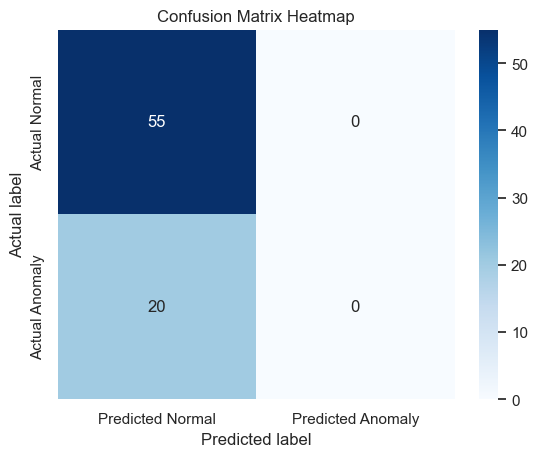

In [45]:
import seaborn as sns

# Assuming tn, fp, fn, tp are defined and represent true negatives, false positives, false negatives, and true positives respectively
conf_matrix = [[tn, fp], [fn, tp]]

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


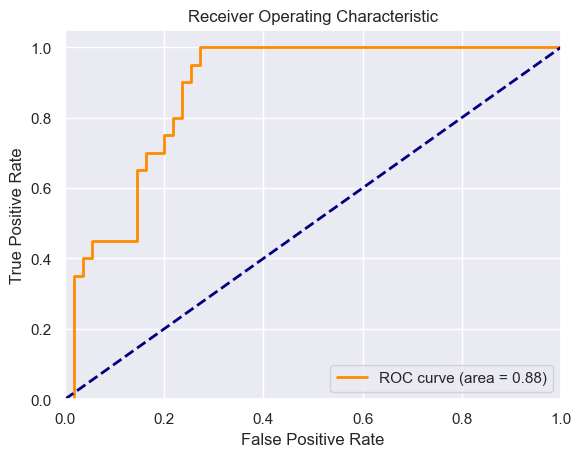

In [48]:
# Use the decision_function to obtain anomaly scores
# Note: Higher scores indicate more normal, lower scores indicate more anomalous
anomaly_scores = best_model.decision_function(X_test)

# Since ROC curve requires positive class probabilities, you might need to transform these scores
# For Isolation Forest, lower scores are more anomalous, so you can invert the scores to interpret them as "probabilities"
prediction_scores = -anomaly_scores  # Inverting scores; now lower scores (more anomalous) have higher "probabilities"

# Continue with your ROC curve plotting
fpr, tpr, thresholds = roc_curve(y_test_simulated, prediction_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


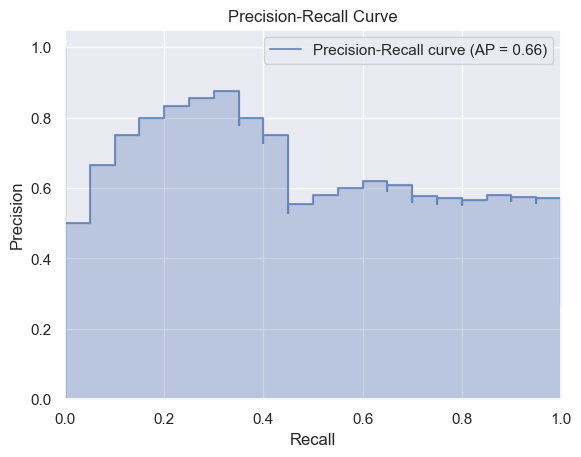

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test_simulated, prediction_scores)
average_precision = average_precision_score(y_test_simulated, prediction_scores)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
